In [1]:
# install necessary packages
!pip install langdetect
!pip install emoji
!pip install contractions
!pip install autocorrect
!pip install spacy
!pip install pyspark
!pip install kaggle
!pip install wordcloud
!pip install lightgbm
!pip install gensim
!pip install scikit-optimize
!pip install lightgbm
!pip install xgboost

In [ ]:
# mount google drive for preprocessed data
from google.colab import drive
drive.mount('/content/drive')

In [3]:
# import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import langdetect
import re
import emoji
import contractions
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('punkt')
from autocorrect import Speller
import spacy
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")
import pyspark
from pyspark.sql import functions as func
from pyspark.sql.types import StringType,FloatType
from pyspark.sql.functions import col
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Twitter').getOrCreate()
spark

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import gensim
from skopt import gp_minimize
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shuawoo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/shuawoo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 19.0 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/12 13:38:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# **Dataset Import**

In [ ]:
# Please ensure having uploaded the kaggle.json file before running
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d kazanova/sentiment140
! unzip sentiment140.zip

 99% 80.0M/80.9M [00:03<00:00, 32.2MB/s]
100% 80.9M/80.9M [00:03<00:00, 23.6MB/s]
Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [ ]:
# Import the dataset
columns  = ["target", "ids", "date", "flag", "user", "text"]
data = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", names = columns)
data.head()

target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....

# **Data Visualization**

In [ ]:
# Check the data size
print("data size: ", data.shape[0])
print("number of ids: ", len(data['ids'].unique()))

data size:  1600000
number of ids:  1598315


In [ ]:
# information of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [ ]:
# filter for useful columns and checking if there is null
data = data[["target", "text"]]
data_n = data[data['target'] == 0]
data_p = data[data['target'] == 4]
data.isnull().any()

# we can see that there is no null value in our datasets

target    False
text      False
dtype: bool

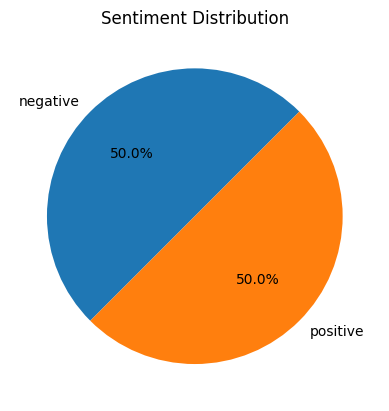

In [ ]:
# check data balance
plt.pie([len(data[data["target"]==0]), len(data[data["target"]==4])], labels=["negative", "positive"], autopct='%1.1f%%', startangle=45)
plt.title("Sentiment Distribution")
plt.show()

From the general review, we can see that the dataset is well-balanced and well distributed regarding the target value, there is no null value in the datasets.

Since the purpose of the analysis is to identify whether a twitter comment is positive or negative, based on the user's content. This can be widely applied to any text classification and prediction.

In [ ]:
# checking the text language
languages = []

for text in data['text']:
    try:
        result = langdetect.detect_langs(text)
        languages.append(result[0].lang)
    except:
        languages.append('unknown')

data["language"] = languages
data["language"].unique()

array(['en', 'ca', 'af', 'no', 'it', 'da', 'pl', 'so', 'pt', 'cy', 'sv',
       'id', 'cs', 'fr', 'nl', 'de', 'es', 'et', 'ro', 'tl', 'sq', 'fi',
       'sk', 'hu', 'vi', 'hr', 'sw', 'tr', 'lv', 'sl', 'lt', 'uk',
       'unknown'], dtype=object)

From the result, we can see that the texts in our datasets are in multiple languages. In the preprocessing stage following, we will filter the english data and check whether the data is balanced again.

# **Data Preprocessing**

   target                                               text language
0       0  @switchfoot http://twitpic.com/2y1zl - Awww, t...       en
1       0  is upset that he can't update his Facebook by ...       en
2       0  @Kenichan I dived many times for the ball. Man...       en
3       0    my whole body feels itchy and like its on fire        en
4       0  @nationwideclass no, it's not behaving at all....       en


Text(0.5, 1.0, 'Sentiment Distribution of English Tweets')

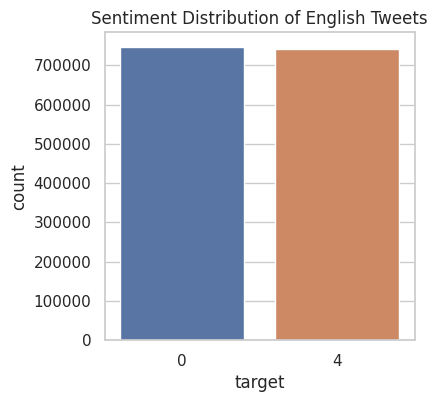

In [ ]:
# filter all english data
en_data = data[data["language"] == "en"]
en_data.to_csv("en_data.csv", index=False)
print(en_data.head())

# see if the dataset is balanced
sns.set(style = "whitegrid")
fig,ax = plt.subplots(figsize=(4, 4))
sns.countplot(x = "target", data = en_data)
plt.title("Sentiment Distribution of English Tweets")

From the bar plot, we can see that the en_dataset is quite balanced, so we can randomly sample 4000 data from negative and positive data (2000 in each category), then combine them together to have our datasets for modeling to save run time.

In [ ]:
# the language detecting takes quite long time, so please import the result directly
en_data = pd.read_csv("/content/drive/Shareddrives/FML-Project/00 data/en_data.csv")

In [ ]:
# sample from en_data
en_data = en_data[["target", "text"]]
data_n = en_data[en_data["target"] == 0]
data_p = en_data[en_data["target"] == 4]
data_n_sample = data_n.sample(n = 20000, random_state = 0)
data_p_sample = data_p.sample(n = 20000, random_state = 0)
sample_data = pd.concat([data_n_sample, data_p_sample], ignore_index=True)

# save the result into csv
sample_data.to_csv("/content/drive/Shareddrives/FML-Project/00 data/sample_data_40000.csv", index=False)
sample_data.head()

target                                               text
0       0  @Dreamps actually that did cross my mind of so...
1       0  Trying to beat Satch Boggie on GH(Wt) and can't. 
2       0  @SamuelJHextall i agree with you sammy...even ...
3       0  Pushed snooze once on my cell before it died. ...
4       0  I wanna have belgian fries with tuna right and...

In [ ]:
def preprocessing(text):
  # lowercase
  text = text.lower()
  # remove emails
  text = re.sub(r'\S+@\S+', '', text)
  # remove usernames
  text = re.sub(r'@\S+', '', text)
  # remove URLs
  text = re.sub(r'http\S+', '', text)
  # replace emojis with their codes
  text = " ".join([" ".join(emoji.demojize(x)[1:-1].split("_")) if emoji.is_emoji(x) else x for x in text.split()])
  # replace abbreviation with full words
  text = contractions.fix(text)
  # replace three and more same letters with one
  text = re.sub(r'(.)\1{2,}', r'\1', text)
  # autocorrect the typos
  spell = Speller()
  text = spell(text)
  # delete non_letter
  text = re.compile('[^a-zA-Z ]').sub('', text)
  # lemmatization
  doc = nlp(text)
  text = " ".join([token.lemma_.lower() for token in doc])
  # remove stopwords
  text = " ".join([word for word in text.split() if word not in stop_words])
  return text.strip()

In [ ]:
sample_data['preprocessed_text'] = sample_data['text'].apply(preprocessing)
sample_data.to_csv('/content/drive/Shareddrives/FML-Project/00 data/preprocessed_data_40000.csv', index=False)

# **Word Cloud**

The preprocessing procedure takes a bit long, please import the preprocessed_data_40000 directly.

In [ ]:
df = spark.read.csv("/content/drive/Shareddrives/FML-Project/00 data/preprocessed_data_40000.csv", header=True, inferSchema=True)

# split the positive and negative texts
positive_texts = df.filter(col("target") == 4.0).select("preprocessed_text").dropna()
negative_texts = df.filter(col("target") == 0.0).select("preprocessed_text").dropna()

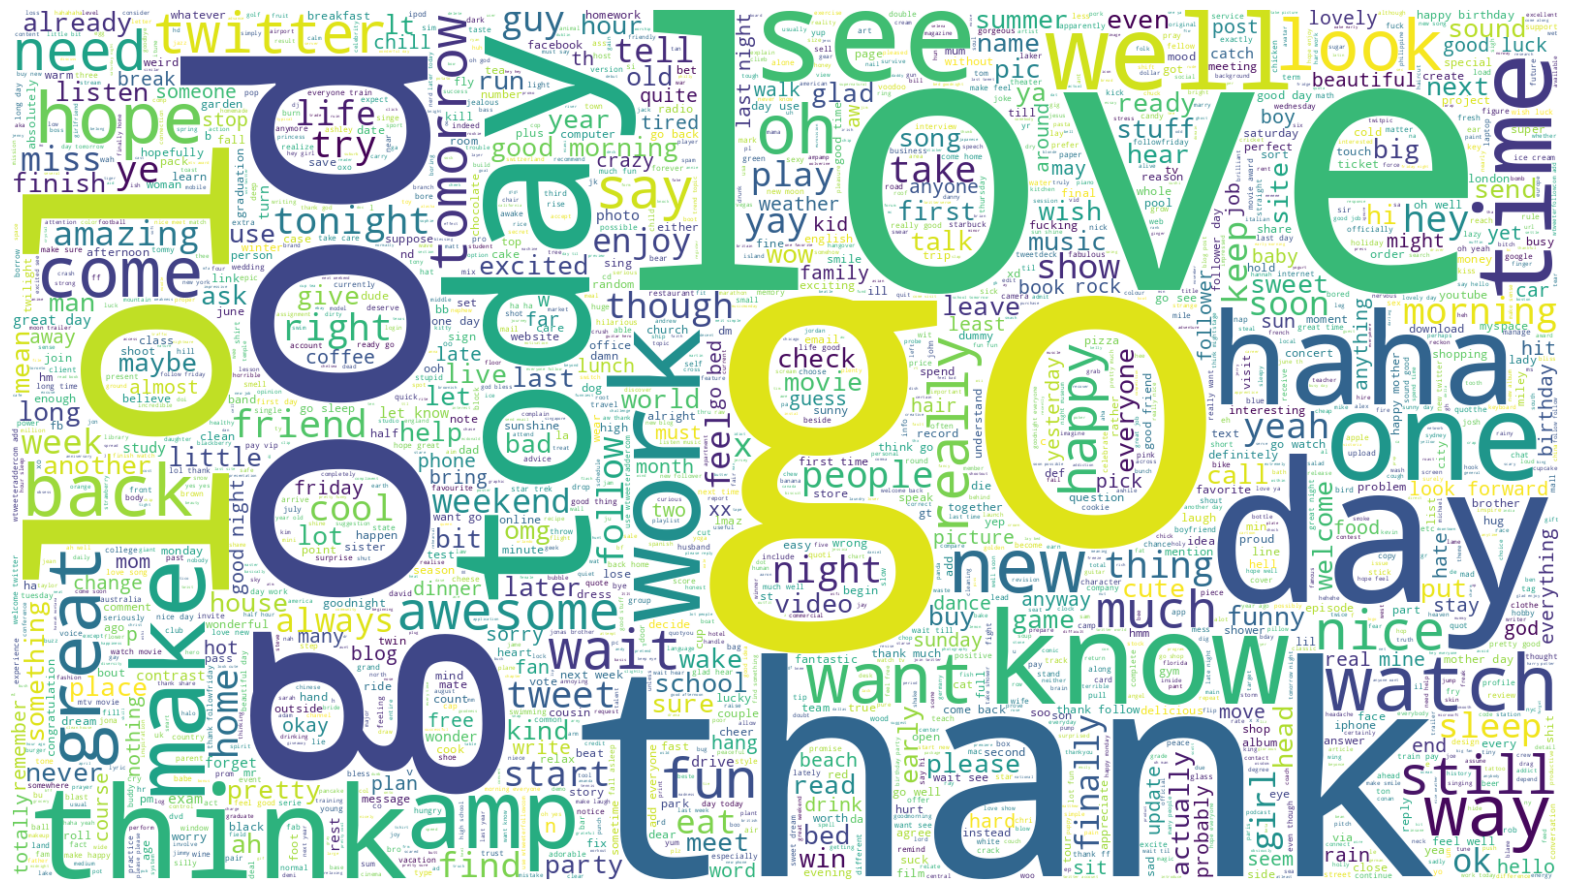

In [ ]:
# Positive wordcloud
positive_texts_list = [row.preprocessed_text for row in positive_texts.collect()]
plt.figure(figsize=(20, 16))
wc_positive = WordCloud(max_words=2000, width=1600, height=900, background_color='white').generate(" ".join(positive_texts_list))
plt.imshow(wc_positive, interpolation='bilinear')
plt.axis("off")
plt.show()

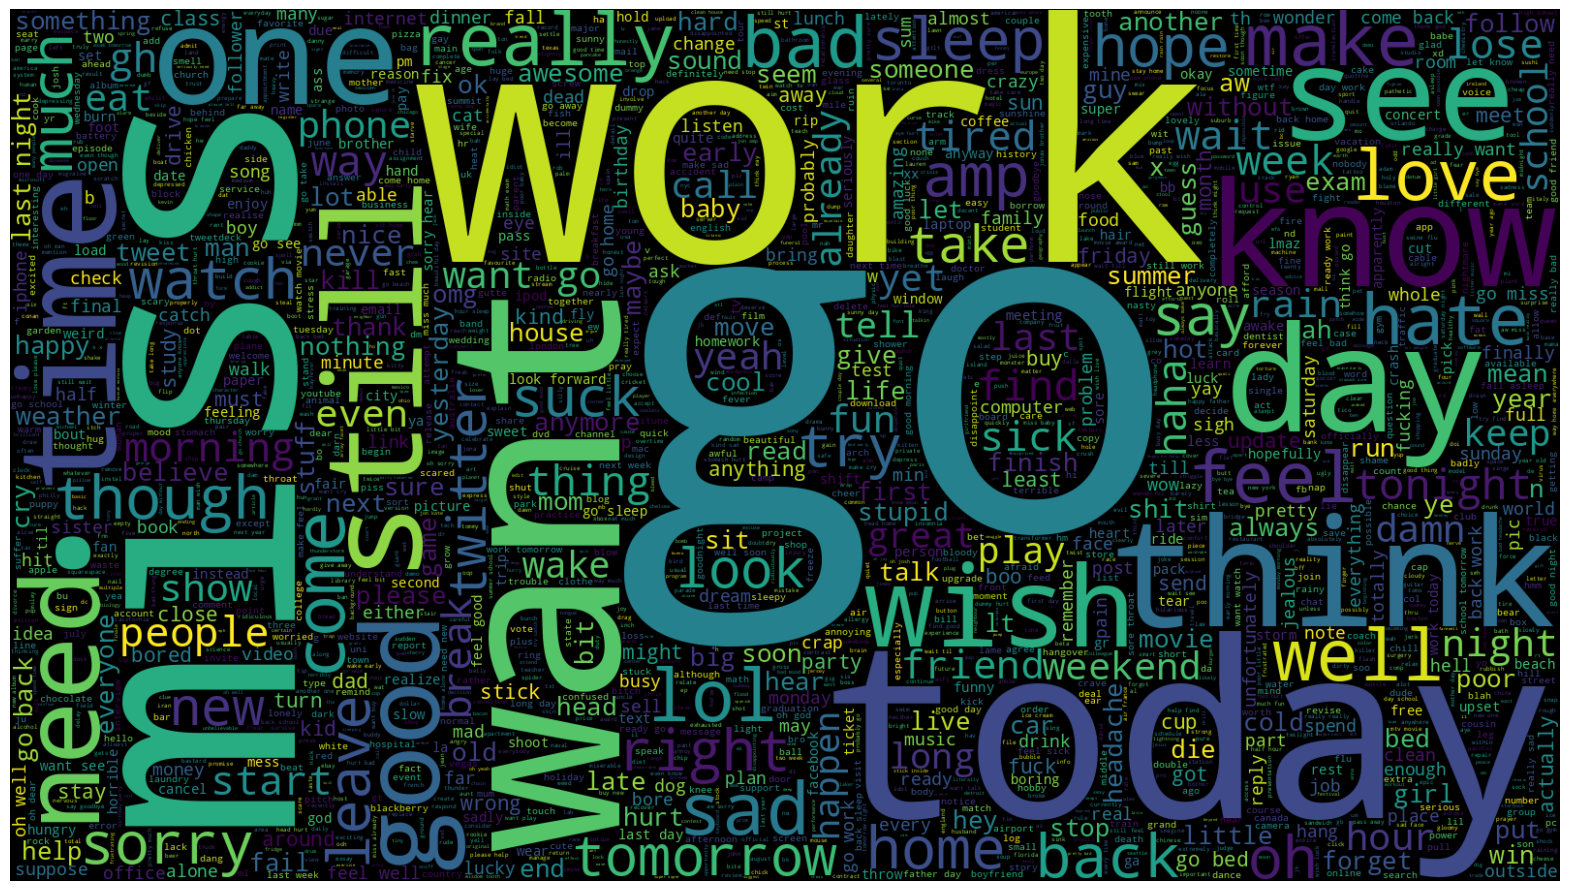

In [ ]:
# Negative wordcloud
negative_texts_list = [row.preprocessed_text for row in negative_texts.collect()]
plt.figure(figsize=(20, 16))
wc_negative = WordCloud(max_words=2000, width=1600, height=900).generate(" ".join(negative_texts_list))
plt.imshow(wc_negative, interpolation='bilinear')
plt.axis("off")
plt.show()

# **Data Processing**

## Split Datasets

In [4]:
preprocessed_data = pd.read_csv("/content/drive/Shareddrives/FML-Project/00 data/preprocessed_data_40000.csv")
preprocessed_data.head()

target                                               text  \
0       0  @Dreamps actually that did cross my mind of so...   
1       0  Trying to beat Satch Boggie on GH(Wt) and can't.    
2       0  @SamuelJHextall i agree with you sammy...even ...   
3       0  Pushed snooze once on my cell before it died. ...   
4       0  I wanna have belgian fries with tuna right and...   

                                   preprocessed_text  
0  actually cross mind something hey able get gar...  
1                          try beat match bogie ghwt  
2  agree spammyeven though know personally like f...  
3  push snooker cell die effect little late work ...  
4          want belgian fry tuna right mustard right

In [5]:
# split the datasets
preprocessed_data = preprocessed_data.dropna(subset=['preprocessed_text'])
x_train_sen, x_temp, y_train, y_temp = train_test_split(preprocessed_data['preprocessed_text'], preprocessed_data.target, test_size=0.3, random_state=0)
x_val_sen, x_test_sen, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=0)
print(x_train_sen.shape, x_test_sen.shape, x_val_sen.shape)

(27906,) (5980,) (5980,)


In [6]:
# encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

print("Encoded y_train:", y_train_encoded)
print("Encoded y_val:", y_val_encoded)
print("Encoded y_test:", y_test_encoded)

Encoded y_train: [1 0 1 ... 1 1 0]
Encoded y_val: [0 0 0 ... 0 1 1]
Encoded y_test: [1 1 0 ... 0 1 0]


## Tf-idf

In [7]:
# Tfidf
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=20000)
vectorizer.fit(preprocessed_data['preprocessed_text'])
X_train_ml = vectorizer.transform(x_train_sen)
X_test_ml = vectorizer.transform(x_temp)
print(X_train_ml.shape, X_test_ml.shape)

(27906, 20000) (11960, 20000)


In [8]:
y_train_ml = y_train
y_test_ml = y_temp
print(y_train_ml.shape, y_test_ml.shape)

(27906,) (11960,)


In [9]:
# check the number of unigrams and bigrams we choose
unigrams_feature_count = sum(' ' not in feature for feature in vectorizer.vocabulary_)
bigrams_feature_count = sum(' ' in feature for feature in vectorizer.vocabulary_)
print("Unigrams feature count:", unigrams_feature_count)
print("Bigrams feature count:", bigrams_feature_count)

Unigrams feature count: 7385
Bigrams feature count: 12615


## Tokenize

In [10]:
# tokenize
tokenizer = Tokenizer()
tokenizer.fit_on_texts(preprocessed_data['preprocessed_text'])
sequences = tokenizer.texts_to_sequences(preprocessed_data['preprocessed_text'])

X_train_tok = tokenizer.texts_to_sequences(x_train_sen)
X_val_tok = tokenizer.texts_to_sequences(x_val_sen)
X_test_tok = tokenizer.texts_to_sequences(x_test_sen)

word_index = tokenizer.word_index
max_length = max(len(sen) for sen in sequences)

print(word_index)
print(max_length)

{'go': 1, 'get': 2, 'good': 3, 'day': 4, 'work': 5, 'like': 6, 'want': 7, 'love': 8, 'today': 9, 'time': 10, 'think': 11, 'know': 12, 'see': 13, 'well': 14, 'back': 15, 'one': 16, 'thank': 17, 'lol': 18, 'make': 19, 'miss': 20, 'really': 21, 'feel': 22, 'come': 23, 'oh': 24, 'watch': 25, 'new': 26, 'night': 27, 'still': 28, 'need': 29, 'home': 30, 'would': 31, 'amp': 32, 'haha': 33, 'much': 34, 'hope': 35, 'look': 36, 'tomorrow': 37, 'great': 38, 'last': 39, 'morning': 40, 'say': 41, 'twitter': 42, 'wait': 43, 'wish': 44, 'sleep': 45, 'way': 46, 'bad': 47, 'take': 48, 'though': 49, 'try': 50, 'could': 51, 'fun': 52, 'right': 53, 'week': 54, 'thing': 55, 'happy': 56, 'sad': 57, 'tonight': 58, 'people': 59, 'friend': 60, 'find': 61, 'sorry': 62, 'nice': 63, 'leave': 64, 'hate': 65, 'bed': 66, 'start': 67, 'yeah': 68, 'follow': 69, 'school': 70, 'show': 71, 'hour': 72, 'play': 73, 'long': 74, 'soon': 75, 'keep': 76, 'tweet': 77, 'eat': 78, 'use': 79, 'awesome': 80, 'weekend': 81, 'hey': 8

In [11]:
vocab_size = len(word_index)
print(vocab_size)

21864


In [12]:
index_word = tokenizer.index_word
print(index_word)

{1: 'go', 2: 'get', 3: 'good', 4: 'day', 5: 'work', 6: 'like', 7: 'want', 8: 'love', 9: 'today', 10: 'time', 11: 'think', 12: 'know', 13: 'see', 14: 'well', 15: 'back', 16: 'one', 17: 'thank', 18: 'lol', 19: 'make', 20: 'miss', 21: 'really', 22: 'feel', 23: 'come', 24: 'oh', 25: 'watch', 26: 'new', 27: 'night', 28: 'still', 29: 'need', 30: 'home', 31: 'would', 32: 'amp', 33: 'haha', 34: 'much', 35: 'hope', 36: 'look', 37: 'tomorrow', 38: 'great', 39: 'last', 40: 'morning', 41: 'say', 42: 'twitter', 43: 'wait', 44: 'wish', 45: 'sleep', 46: 'way', 47: 'bad', 48: 'take', 49: 'though', 50: 'try', 51: 'could', 52: 'fun', 53: 'right', 54: 'week', 55: 'thing', 56: 'happy', 57: 'sad', 58: 'tonight', 59: 'people', 60: 'friend', 61: 'find', 62: 'sorry', 63: 'nice', 64: 'leave', 65: 'hate', 66: 'bed', 67: 'start', 68: 'yeah', 69: 'follow', 70: 'school', 71: 'show', 72: 'hour', 73: 'play', 74: 'long', 75: 'soon', 76: 'keep', 77: 'tweet', 78: 'eat', 79: 'use', 80: 'awesome', 81: 'weekend', 82: 'hey

24/01/12 13:39:03 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [42]:
# padding
X_train_padded = pad_sequences(X_train_tok, maxlen=max_length, padding='post')
X_val_padded = pad_sequences(X_val_tok, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_tok, maxlen=max_length, padding='post')

In [43]:
# inspection
print(X_train_padded.shape, X_val_padded.shape, X_test_padded.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(27906, 25) (5980, 25) (5980, 25)
(27906,) (5980,) (5980,)


# **Machine Learning Model Application**

## 🚩Logistic Regression

In [25]:
warnings.filterwarnings("ignore")

params = {'C':[0.0001, 0.53, 1, 100, 1000],
          'max_iter':[10, 100, 500, 1000],
          'class_weight':['balanced', None],
          'solver':['liblinear','sag','lbfgs','newton-cg']
         }
lr = LogisticRegression()
clf = GridSearchCV(lr, param_grid=params, cv=5)
clf.fit(X_train_ml, y_train_ml)

print(clf.best_params_)
print("Best Parameters:", clf.best_params_)
print("Best Score:", clf.best_score_)

{'C': 1, 'class_weight': 'balanced', 'max_iter': 10, 'solver': 'liblinear'}
Best Parameters: {'C': 1, 'class_weight': 'balanced', 'max_iter': 10, 'solver': 'liblinear'}
Best Score: 0.7374759117394964


In [26]:
lr_model = LogisticRegression(**clf.best_params_)
lr_model.fit(X_train_ml, y_train_ml)

LogisticRegression(C=1, class_weight='balanced', max_iter=10,
                   solver='liblinear')

In [27]:
predictions = lr_model.predict(X_test_ml)
accuracy = accuracy_score(y_test_ml, predictions)
print("Accuracy", f': {accuracy}')

Accuracy : 0.7489130434782608


## 🚩Naive Bayes

In [11]:
warnings.filterwarnings("ignore")

params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]
         }
nb = MultinomialNB()
cnb = GridSearchCV(nb, param_grid=params, cv=5)
cnb.fit(X_train_ml, y_train_ml)

print("Best Parameters:", cnb.best_params_)
print("Best Score:", cnb.best_score_)

Best Parameters: {'alpha': 10}
Best Score: 0.7343941808502013


In [42]:
nb_model = MultinomialNB(**cnb.best_params_)
nb_model.fit(X_train_ml, y_train_ml)

MultinomialNB(alpha=10)

In [43]:
nb_model.fit(X_train_ml, y_train_ml)
predictions = nb_model.predict(X_test_ml)
accuracy = accuracy_score(y_test_ml, predictions)
print("Accuracy", f': {accuracy}')

Accuracy : 0.7485785953177257


## 🚩Random Forest

In [36]:
param_dist = {
    'max_features': ['log2', 'sqrt'], 
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 100],
    'min_samples_split': [50, 100, 200],
}

rf = RandomForestClassifier()
crf = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1)
crf.fit(X_train_ml, y_train_ml)

print("Best Parameters:", crf.best_params_)
print("Best Score:", crf.best_score_)

Best Parameters: {'n_estimators': 200, 'min_samples_split': 200, 'max_features': 'log2', 'max_depth': None}
Best Score: 0.7324231051879132


In [41]:
rf_model = RandomForestClassifier(**crf.best_params_)
rf_model.fit(X_train_ml, y_train_ml)

RandomForestClassifier(max_features='log2', min_samples_split=200,
                       n_estimators=200)

In [42]:
predictions = rf_model.predict(X_test_ml)
accuracy = accuracy_score(y_test_ml, predictions)
print("Accuracy", f': {accuracy}')

Accuracy : 0.7453177257525083


## 🚩KNN

In [19]:
warnings.filterwarnings("ignore")

param_grid = {
    'n_neighbors': [10, 300, 400],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto']
}

knn = KNeighborsClassifier()
cknn = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
cknn.fit(X_train_ml, y_train_ml)

print("Best Parameters:", cknn.best_params_)
print("Test Accuracy:", cknn.best_score_)

Best Parameters: {'algorithm': 'auto', 'n_neighbors': 300, 'weights': 'uniform'}
Test Accuracy: 0.7189853466465758


In [43]:
knn_model = KNeighborsClassifier(**cknn.best_params_)
knn_model.fit(X_train_ml, y_train_ml)

KNeighborsClassifier(n_neighbors=300)

In [44]:
predictions = knn_model.predict(X_test_ml)
accuracy = accuracy_score(y_test_ml, predictions)
print("Accuracy", f': {accuracy}')

Accuracy : 0.722742474916388


## 🚩SVM

In [49]:
warnings.filterwarnings("ignore")

parameters={'kernel':['linear','rbf','sigmoid','poly'],
            'C':[1e-2, 1e-1, 1, 10, 100],
            'gamma':[1e-6, 'auto', 1e-4, 0.1, 1]}

svm = SVC()
csvm = GridSearchCV(svm,parameters,cv=5,scoring='accuracy')
csvm.fit(X_train_ml,y_train_ml)

print("Best Parameters:", csvm.best_params_)
print("Best Accuracy:", csvm.score(X_test_ml, y_test_ml))

Best Parameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Best Accuracy: 0.7482441471571907


In [ ]:
svm_model = SVC(**csvm.best_params_, probability=True)
svm_model.fit(X_train_ml, y_train_ml)

In [40]:
predictions = svm_model.predict(X_test_ml)
accuracy = accuracy_score(y_test_ml, predictions)
print("Accuracy", f': {accuracy}')

Accuracy : 0.7482441471571907


## 🚩AdaBoost

In [23]:
warnings.filterwarnings("ignore")

param_space = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.5, 1.0, 2.0],
    'base_estimator__max_features': ['log2', 'sqrt', None],
    'base_estimator__max_depth': [2, 10, 50]
}

adb = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

cadb = BayesSearchCV(adb, param_space, n_iter=50, cv=5, scoring='accuracy')
cadb.fit(X_train_ml, y_train_ml)

print("Best Parameters:", cadb.best_params_)
print("Best Score:", cadb.best_score_)

Best Parameters: OrderedDict([('base_estimator__max_depth', 2), ('base_estimator__max_features', None), ('learning_rate', 0.5), ('n_estimators', 300)])
Best Score: 0.7170502095743666


In [54]:
base_classifier = DecisionTreeClassifier(max_depth=2, max_features=None)

adb_model = AdaBoostClassifier(base_estimator=base_classifier,
                               learning_rate=0.5,
                               n_estimators=300)
adb_model.fit(X_train_ml, y_train_ml)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=0.5, n_estimators=300)

In [55]:
predictions = adb_model.predict(X_test_ml)
accuracy = accuracy_score(y_test_ml, predictions)
print("Accuracy", f': {accuracy}')

Accuracy : 0.7158862876254181


## 🚩LGBM

In [ ]:
warnings.filterwarnings("ignore")

param_grid = {
    'max_depth': [3, 4, 6],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.01, 1],
    'reg_lambda': [0, 0.1, 1]
}

lgbm = LGBMClassifier()

clgbm = BayesSearchCV(lgbm, param_grid, n_iter=50, cv=5, scoring='accuracy')
clgbm.fit(X_train_ml, y_train_ml)

print("Best Parameters:", clgbm.best_params_)
print("Best Score:", clgbm.best_score_)

Best Parameters: OrderedDict([('colsample_bytree', 0.7), ('max_depth', 6), ('reg_alpha', 0.01), ('reg_lambda', 0.1), ('subsample', 0.9)])
Best Score: 0.7002797534836134


In [ ]:
lgbm_model = LGBMClassifier(**clgbm.best_params_)
lgbm_model.fit(X_train_ml, y_train_ml)

LGBMClassifier(colsample_bytree=0.7, max_depth=6, reg_alpha=0.01,
               reg_lambda=0.1, subsample=0.9)

In [ ]:
predictions = lgbm_model.predict(X_test_ml)
accuracy = accuracy_score(y_test_ml, predictions)
print("Accuracy", f': {accuracy}')

Accuracy : 0.6948160535117057


## 🚩XGBoost

In [17]:
warnings.filterwarnings("ignore")

param_space = {
    'n_estimators': [600, 1000, 1500],
    'learning_rate': [0.1, 0.3, 0.5],
    'base_estimator__colsample_bytree': [0.5, 0.8, 1],
    'base_estimator__max_depth': [4, 6, 8]
}

xgb = XGBClassifier(base_estimator=DecisionTreeClassifier())

cxgb = BayesSearchCV(xgb, param_space, n_iter=50, cv=5, scoring='accuracy')
cxgb.fit(X_train_ml, y_train_encoded)

print("Best Parameters:", cxgb.best_params_)
print("Best Score:", cxgb.best_score_)

Best Parameters: OrderedDict([('base_estimator__colsample_bytree', 0.5), ('base_estimator__max_depth', 4), ('learning_rate', 0.1), ('n_estimators', 1000)])
Best Score: 0.7214578099377584


In [26]:
xgb_model = XGBClassifier(**cxgb.best_params_)
xgb_model.fit(X_train_ml, y_train_encoded)

XGBClassifier(base_estimator__colsample_bytree=0.5, base_estimator__max_depth=4,
              base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None, ...)

In [29]:
y_test_binary = y_test_ml.replace({4: 1})

predictions = xgb_model.predict(X_test_ml)
accuracy = accuracy_score(y_test_binary, predictions)
print("Accuracy", f': {accuracy}')

Accuracy : 0.7267558528428094


# **Deep Learning Model Application**

# 🚩 Self-learning Embedding

## 🚩ANN

In [ ]:
model = Sequential()
model.add(Embedding(input_dim =vocab_size + 1, output_dim = 100, input_length = max_length))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 100)           2186500   
                                                                 
 flatten (Flatten)           (None, 2500)              0         
                                                                 
 dense (Dense)               (None, 64)                160064    
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2348677 (8.96 MB)
Trainable params: 2348677 (8.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(X_train_padded, y_train_encoded, validation_data=(X_val_padded,y_val_encoded), epochs=10, batch_size=128, verbose=1)
result = model.evaluate(X_test_padded,y_test_encoded)
result

Epoch 1/10
219/219 [==============================] - 26s 89ms/step - loss: 0.6895 - accuracy: 0.5417 - val_loss: 0.6798 - val_accuracy: 0.6017
Epoch 2/10
219/219 [==============================] - 11s 52ms/step - loss: 0.6347 - accuracy: 0.6802 - val_loss: 0.5878 - val_accuracy: 0.7015
Epoch 3/10
219/219 [==============================] - 9s 42ms/step - loss: 0.5262 - accuracy: 0.7581 - val_loss: 0.5451 - val_accuracy: 0.7253
Epoch 4/10
219/219 [==============================] - 11s 49ms/step - loss: 0.4567 - accuracy: 0.7976 - val_loss: 0.5366 - val_accuracy: 0.7296
Epoch 5/10
219/219 [==============================] - 10s 46ms/step - loss: 0.4005 - accuracy: 0.8313 - val_loss: 0.5429 - val_accuracy: 0.7323
Epoch 6/10
219/219 [==============================] - 10s 46ms/step - loss: 0.3481 - accuracy: 0.8596 - val_loss: 0.5584 - val_accuracy: 0.7269
Epoch 7/10
219/219 [==============================] - 11s 50ms/step - loss: 0.2963 - accuracy: 0.8880 - val_loss: 0.5846 - val_accuracy: 

[0.6998993158340454, 0.7016722559928894]

## 🚩LSTM

In [ ]:
model = Sequential()
model.add(Embedding(input_dim = vocab_size + 1, output_dim = 100, input_length = max_length))
model.add(LSTM(units=128, dropout=0.2, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 25, 100)           2186500   
                                                                 
 lstm (LSTM)                 (None, 25, 128)           117248    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2357381 (8.99 MB)
Trainable params: 2357

In [ ]:
model.fit(X_train_padded, y_train_encoded, validation_data=(X_val_padded,y_val_encoded), epochs=10, batch_size=128, verbose=1)
result = model.evaluate(X_test_padded,y_test_encoded)
result

Epoch 1/10
219/219 [==============================] - 49s 206ms/step - loss: 0.6929 - accuracy: 0.5083 - val_loss: 0.6918 - val_accuracy: 0.5117
Epoch 2/10
219/219 [==============================] - 47s 213ms/step - loss: 0.5920 - accuracy: 0.6870 - val_loss: 0.5423 - val_accuracy: 0.7239
Epoch 3/10
219/219 [==============================] - 43s 197ms/step - loss: 0.5044 - accuracy: 0.7591 - val_loss: 0.5299 - val_accuracy: 0.7309
Epoch 4/10
219/219 [==============================] - 43s 198ms/step - loss: 0.4627 - accuracy: 0.7884 - val_loss: 0.5490 - val_accuracy: 0.7172
Epoch 5/10
219/219 [==============================] - 46s 210ms/step - loss: 0.4349 - accuracy: 0.8067 - val_loss: 0.5383 - val_accuracy: 0.7303
Epoch 6/10
219/219 [==============================] - 44s 202ms/step - loss: 0.4093 - accuracy: 0.8208 - val_loss: 0.5582 - val_accuracy: 0.7288
Epoch 7/10
219/219 [==============================] - 41s 188ms/step - loss: 0.3838 - accuracy: 0.8344 - val_loss: 0.6104 - val_ac

[0.660923421382904, 0.7147157192230225]

## 🚩GRU

In [ ]:
model = Sequential()
model.add(Embedding(input_dim = vocab_size + 1, output_dim = 100, input_length = max_length))
model.add(GRU(128, dropout=0.2, return_sequences=True))
model.add(GRU(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 100)           2186500   
                                                                 
 gru (GRU)                   (None, 25, 128)           88320     
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2316293 (8.84 MB)
Trainable params: 231629

In [ ]:
model.fit(X_train_padded, y_train_encoded, validation_data=(X_val_padded,y_val_encoded), epochs=10, batch_size=128, verbose=1)
result = model.evaluate(X_test_padded,y_test_encoded)
result

Epoch 1/10
219/219 [==============================] - 104s 388ms/step - loss: 0.6933 - accuracy: 0.4996 - val_loss: 0.6931 - val_accuracy: 0.5050
Epoch 2/10
219/219 [==============================] - 64s 293ms/step - loss: 0.6933 - accuracy: 0.5027 - val_loss: 0.6934 - val_accuracy: 0.4950
Epoch 3/10
219/219 [==============================] - 59s 268ms/step - loss: 0.6933 - accuracy: 0.4999 - val_loss: 0.6932 - val_accuracy: 0.4950
Epoch 4/10
219/219 [==============================] - 38s 174ms/step - loss: 0.6933 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.4950
Epoch 5/10
219/219 [==============================] - 38s 174ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6932 - val_accuracy: 0.4950
Epoch 6/10
219/219 [==============================] - 46s 211ms/step - loss: 0.6932 - accuracy: 0.4993 - val_loss: 0.6932 - val_accuracy: 0.4950
Epoch 7/10
219/219 [==============================] - 56s 254ms/step - loss: 0.6932 - accuracy: 0.4981 - val_loss: 0.6932 - val_a

[0.6930817365646362, 0.50551837682724]

## 🚩LSTM - Bidirectional

In [ ]:
model = Sequential()
model.add(Embedding(input_dim = vocab_size + 1, output_dim = 100, input_length = max_length))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics=['accuracy'])

In [ ]:
model.fit(X_train_padded, y_train_encoded, validation_data=(X_val_padded,y_val_encoded), epochs=10, batch_size=128, verbose=1)
result = model.evaluate(X_test_padded,y_test_encoded)
result

Epoch 1/10
219/219 [==============================] - 90s 370ms/step - loss: 0.6844 - accuracy: 0.5578 - val_loss: 0.5980 - val_accuracy: 0.6729
Epoch 2/10
219/219 [==============================] - 79s 361ms/step - loss: 0.5345 - accuracy: 0.7400 - val_loss: 0.5322 - val_accuracy: 0.7338
Epoch 3/10
219/219 [==============================] - 82s 373ms/step - loss: 0.4704 - accuracy: 0.7873 - val_loss: 0.5807 - val_accuracy: 0.6946
Epoch 4/10
219/219 [==============================] - 80s 366ms/step - loss: 0.4278 - accuracy: 0.8143 - val_loss: 0.5450 - val_accuracy: 0.7289
Epoch 5/10
219/219 [==============================] - 81s 368ms/step - loss: 0.3909 - accuracy: 0.8379 - val_loss: 0.5565 - val_accuracy: 0.7258
Epoch 6/10
219/219 [==============================] - 80s 366ms/step - loss: 0.3612 - accuracy: 0.8543 - val_loss: 0.6197 - val_accuracy: 0.7017
Epoch 7/10
219/219 [==============================] - 85s 389ms/step - loss: 0.3372 - accuracy: 0.8642 - val_loss: 0.6258 - val_ac

[0.7515048384666443, 0.7073578834533691]

## 🚩CNN

In [ ]:
model = Sequential()
model.add(Embedding(input_dim = vocab_size + 1, output_dim = 100, input_length = max_length))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics=['accuracy'])

In [ ]:
model.fit(X_train_padded, y_train_encoded, validation_data=(X_val_padded,y_val_encoded), epochs=10, batch_size=128, verbose=1)
result = model.evaluate(X_test_padded,y_test_encoded)
result

Epoch 1/10
219/219 [==============================] - 17s 72ms/step - loss: 0.6917 - accuracy: 0.5263 - val_loss: 0.6880 - val_accuracy: 0.5910
Epoch 2/10
219/219 [==============================] - 15s 69ms/step - loss: 0.6709 - accuracy: 0.6423 - val_loss: 0.6363 - val_accuracy: 0.7055
Epoch 3/10
219/219 [==============================] - 15s 67ms/step - loss: 0.5631 - accuracy: 0.7404 - val_loss: 0.5327 - val_accuracy: 0.7336
Epoch 4/10
219/219 [==============================] - 15s 70ms/step - loss: 0.4731 - accuracy: 0.7812 - val_loss: 0.5153 - val_accuracy: 0.7438
Epoch 5/10
219/219 [==============================] - 15s 70ms/step - loss: 0.4243 - accuracy: 0.8160 - val_loss: 0.5190 - val_accuracy: 0.7415
Epoch 6/10
219/219 [==============================] - 15s 70ms/step - loss: 0.3813 - accuracy: 0.8390 - val_loss: 0.5319 - val_accuracy: 0.7411
Epoch 7/10
219/219 [==============================] - 16s 71ms/step - loss: 0.3448 - accuracy: 0.8582 - val_loss: 0.5506 - val_accuracy:

[0.6420024633407593, 0.7224080562591553]

## 🚩GRU - Bidirectional

In [ ]:
model = Sequential()
model.add(Embedding(input_dim = vocab_size + 1, output_dim = 100, input_length = max_length))
model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Bidirectional(GRU(64)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics=['accuracy'])

In [ ]:
model.fit(X_train_padded, y_train_encoded, validation_data=(X_val_padded,y_val_encoded), epochs=10, batch_size=128, verbose=1)
result = model.evaluate(X_test_padded,y_test_encoded)
result

Epoch 1/10
219/219 [==============================] - 82s 335ms/step - loss: 0.6752 - accuracy: 0.5874 - val_loss: 0.5948 - val_accuracy: 0.6946
Epoch 2/10
219/219 [==============================] - 67s 307ms/step - loss: 0.5355 - accuracy: 0.7370 - val_loss: 0.5363 - val_accuracy: 0.7329
Epoch 3/10
219/219 [==============================] - 70s 318ms/step - loss: 0.4688 - accuracy: 0.7892 - val_loss: 0.5377 - val_accuracy: 0.7308
Epoch 4/10
219/219 [==============================] - 75s 343ms/step - loss: 0.4254 - accuracy: 0.8187 - val_loss: 0.5715 - val_accuracy: 0.7221
Epoch 5/10
219/219 [==============================] - 69s 317ms/step - loss: 0.3846 - accuracy: 0.8424 - val_loss: 0.5753 - val_accuracy: 0.7281
Epoch 6/10
219/219 [==============================] - 68s 313ms/step - loss: 0.3604 - accuracy: 0.8567 - val_loss: 0.6151 - val_accuracy: 0.7187
Epoch 7/10
219/219 [==============================] - 74s 338ms/step - loss: 0.3293 - accuracy: 0.8716 - val_loss: 0.6353 - val_ac

[0.7577013969421387, 0.7050167322158813]

---

# 🚩 Custom Word2Vec

In [ ]:
epochs_ = 10
batch_size_ = 128
embedding_len = 100

In [ ]:
word2vec_custom = Word2Vec(list(map(lambda x: word_tokenize(x), preprocessed_data['preprocessed_text'])),
                 vector_size = embedding_len,
                 workers=8,
                 min_count = 1)

vocab_size = len(word2vec_custom.wv.key_to_index)

In [ ]:
embedding_matrix_c = np.zeros((vocab_size + 1, embedding_len))

for word, token in tokenizer.word_index.items():
    if word2vec_custom.wv.__contains__(word):
        embedding_matrix_c[token] = word2vec_custom.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix_c.shape)

Embedding Matrix Shape: (21866, 100)


## 🚩ANN with Custom Word2Vec

In [ ]:
model = Sequential()
model.add(Embedding(input_dim = vocab_size+1,output_dim = embedding_len,weights=[embedding_matrix_c],input_length = max_length,trainable = False))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics=['accuracy'])
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 25, 100)           2186600   
                                                                 
 flatten_2 (Flatten)         (None, 2500)              0         
                                                                 
 dense_32 (Dense)            (None, 64)                160064    
                                                                 
 dense_33 (Dense)            (None, 32)                2080      
                                                                 
 dense_34 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2348777 (8.96 MB)
Trainable params: 162177 (633.50 KB)
Non-trainable params: 2186600 (8.34 MB)
_________________________________________________________________


In [ ]:
model.fit(X_train_padded, y_train_encoded, validation_data=(X_val_padded,y_val_encoded), epochs=epochs_, batch_size=batch_size_, verbose=1)
result = model.evaluate(X_test_padded,y_test_encoded)
result

Epoch 1/10
219/219 [==============================] - 3s 8ms/step - loss: 0.6845 - accuracy: 0.5492 - val_loss: 0.6770 - val_accuracy: 0.5758
Epoch 2/10
219/219 [==============================] - 2s 7ms/step - loss: 0.6721 - accuracy: 0.5763 - val_loss: 0.6687 - val_accuracy: 0.5804
Epoch 3/10
219/219 [==============================] - 2s 7ms/step - loss: 0.6672 - accuracy: 0.5851 - val_loss: 0.6640 - val_accuracy: 0.5888
Epoch 4/10
219/219 [==============================] - 3s 12ms/step - loss: 0.6617 - accuracy: 0.5945 - val_loss: 0.6595 - val_accuracy: 0.5903
Epoch 5/10
219/219 [==============================] - 3s 12ms/step - loss: 0.6577 - accuracy: 0.5999 - val_loss: 0.6578 - val_accuracy: 0.5950
Epoch 6/10
219/219 [==============================] - 2s 8ms/step - loss: 0.6565 - accuracy: 0.5996 - val_loss: 0.6610 - val_accuracy: 0.5895
Epoch 7/10
219/219 [==============================] - 2s 7ms/step - loss: 0.6544 - accuracy: 0.6053 - val_loss: 0.6720 - val_accuracy: 0.5856
Epoc

[0.6539797782897949, 0.6053511500358582]

## 🚩LSTM with Custom Word2Vec


In [ ]:
model = Sequential()
model.add(Embedding(input_dim = vocab_size+1,output_dim = embedding_len,weights=[embedding_matrix_c],input_length = max_length,trainable = False))
model.add(LSTM(units=128, dropout=0.2, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics=['accuracy'])
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 25, 100)           2186600   
                                                                 
 lstm_8 (LSTM)               (None, 25, 128)           117248    
                                                                 
 lstm_9 (LSTM)               (None, 64)                49408     
                                                                 
 dense_35 (Dense)            (None, 64)                4160      
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_36 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2357481 (8.99 MB)
Trainable params: 170

In [ ]:
model.fit(X_train_padded, y_train_encoded, validation_data=(X_val_padded,y_val_encoded), epochs=epochs_, batch_size=batch_size_, verbose=1)
result = model.evaluate(X_test_padded,y_test_encoded)
result

Epoch 1/10
219/219 [==============================] - 40s 154ms/step - loss: 0.6854 - accuracy: 0.5476 - val_loss: 0.6739 - val_accuracy: 0.5736
Epoch 2/10
219/219 [==============================] - 33s 153ms/step - loss: 0.6727 - accuracy: 0.5839 - val_loss: 0.6593 - val_accuracy: 0.5993
Epoch 3/10
219/219 [==============================] - 33s 152ms/step - loss: 0.6673 - accuracy: 0.5903 - val_loss: 0.6668 - val_accuracy: 0.6010
Epoch 4/10
219/219 [==============================] - 33s 150ms/step - loss: 0.6643 - accuracy: 0.5939 - val_loss: 0.6532 - val_accuracy: 0.6072
Epoch 5/10
219/219 [==============================] - 33s 150ms/step - loss: 0.6595 - accuracy: 0.6012 - val_loss: 0.6489 - val_accuracy: 0.6115
Epoch 6/10
219/219 [==============================] - 33s 150ms/step - loss: 0.6585 - accuracy: 0.6032 - val_loss: 0.6471 - val_accuracy: 0.6159
Epoch 7/10
219/219 [==============================] - 36s 162ms/step - loss: 0.6556 - accuracy: 0.6062 - val_loss: 0.6457 - val_ac

[0.6357321739196777, 0.6274247765541077]

## 🚩GRU with Custom Word2Vec


In [ ]:
model = Sequential()
model.add(Embedding(input_dim = vocab_size+1,output_dim = embedding_len,weights=[embedding_matrix_c],input_length = max_length,trainable = False))
model.add(GRU(128, dropout=0.2, return_sequences=True))
model.add(GRU(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics=['accuracy'])
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 25, 100)           2186600   
                                                                 
 gru_10 (GRU)                (None, 25, 128)           88320     
                                                                 
 gru_11 (GRU)                (None, 64)                37248     
                                                                 
 dense_37 (Dense)            (None, 64)                4160      
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_38 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2316393 (8.84 MB)
Trainable params: 129

In [ ]:
model.fit(X_train_padded, y_train_encoded, validation_data=(X_val_padded,y_val_encoded), epochs=epochs_, batch_size=batch_size_, verbose=1)
result = model.evaluate(X_test_padded,y_test_encoded)
result

Epoch 1/10
219/219 [==============================] - 34s 135ms/step - loss: 0.6926 - accuracy: 0.5120 - val_loss: 0.6916 - val_accuracy: 0.5209
Epoch 2/10
219/219 [==============================] - 28s 130ms/step - loss: 0.6896 - accuracy: 0.5379 - val_loss: 0.6818 - val_accuracy: 0.5657
Epoch 3/10
219/219 [==============================] - 30s 137ms/step - loss: 0.6783 - accuracy: 0.5665 - val_loss: 0.6697 - val_accuracy: 0.5826
Epoch 4/10
219/219 [==============================] - 30s 136ms/step - loss: 0.6727 - accuracy: 0.5771 - val_loss: 0.6643 - val_accuracy: 0.5841
Epoch 5/10
219/219 [==============================] - 31s 142ms/step - loss: 0.6701 - accuracy: 0.5846 - val_loss: 0.6624 - val_accuracy: 0.5967
Epoch 6/10
219/219 [==============================] - 28s 130ms/step - loss: 0.6685 - accuracy: 0.5911 - val_loss: 0.6609 - val_accuracy: 0.5962
Epoch 7/10
219/219 [==============================] - 28s 128ms/step - loss: 0.6672 - accuracy: 0.5914 - val_loss: 0.6641 - val_ac

[0.6577213406562805, 0.6046822667121887]

## 🚩CNN with Custom Word2Vec

In [ ]:
model = Sequential()
model.add(Embedding(input_dim = vocab_size+1,output_dim = embedding_len,weights=[embedding_matrix_c],input_length = max_length,trainable = False))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics=['accuracy'])
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 25, 100)           2186600   
                                                                 
 conv1d_4 (Conv1D)           (None, 21, 128)           64128     
                                                                 
 global_max_pooling1d_6 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_39 (Dense)            (None, 128)               16512     
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_40 (Dense)            (None, 1)                 129       
                                                     

In [ ]:
model.fit(X_train_padded, y_train_encoded, validation_data=(X_val_padded,y_val_encoded), epochs=epochs_, batch_size=batch_size_, verbose=1)
result = model.evaluate(X_test_padded,y_test_encoded)
result

Epoch 1/10
219/219 [==============================] - 8s 32ms/step - loss: 0.6913 - accuracy: 0.5347 - val_loss: 0.6815 - val_accuracy: 0.5620
Epoch 2/10
219/219 [==============================] - 5s 22ms/step - loss: 0.6800 - accuracy: 0.5627 - val_loss: 0.6743 - val_accuracy: 0.5819
Epoch 3/10
219/219 [==============================] - 6s 29ms/step - loss: 0.6728 - accuracy: 0.5794 - val_loss: 0.6699 - val_accuracy: 0.5905
Epoch 4/10
219/219 [==============================] - 6s 27ms/step - loss: 0.6679 - accuracy: 0.5887 - val_loss: 0.6650 - val_accuracy: 0.5921
Epoch 5/10
219/219 [==============================] - 5s 23ms/step - loss: 0.6640 - accuracy: 0.5935 - val_loss: 0.6603 - val_accuracy: 0.5962
Epoch 6/10
219/219 [==============================] - 7s 33ms/step - loss: 0.6601 - accuracy: 0.5993 - val_loss: 0.6641 - val_accuracy: 0.5851
Epoch 7/10
219/219 [==============================] - 5s 22ms/step - loss: 0.6569 - accuracy: 0.6040 - val_loss: 0.6548 - val_accuracy: 0.6045

[0.6501551866531372, 0.6091973185539246]

## 🚩LSTM - Bidirectional with Custom Word2Vec

In [ ]:
model = Sequential()
model.add(Embedding(input_dim = vocab_size+1,output_dim = embedding_len,weights=[embedding_matrix_c],input_length = max_length,trainable = False))
model.add(Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)))
model.add(Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics=['accuracy'])
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 25, 100)           2186600   
                                                                 
 bidirectional_8 (Bidirecti  (None, 25, 200)           160800    
 onal)                                                           
                                                                 
 bidirectional_9 (Bidirecti  (None, 25, 200)           240800    
 onal)                                                           
                                                                 
 global_max_pooling1d_7 (Gl  (None, 200)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_41 (Dense)            (None, 16)                3216      
                                                     

In [ ]:
model.fit(X_train_padded, y_train_encoded, validation_data=(X_val_padded,y_val_encoded), epochs=epochs_, batch_size=batch_size_, verbose=1)
result = model.evaluate(X_test_padded,y_test_encoded)
result

Epoch 1/10
219/219 [==============================] - 88s 348ms/step - loss: 0.6881 - accuracy: 0.5433 - val_loss: 0.6822 - val_accuracy: 0.5527
Epoch 2/10
219/219 [==============================] - 67s 306ms/step - loss: 0.6810 - accuracy: 0.5638 - val_loss: 0.6742 - val_accuracy: 0.5761
Epoch 3/10
219/219 [==============================] - 74s 336ms/step - loss: 0.6743 - accuracy: 0.5763 - val_loss: 0.6717 - val_accuracy: 0.5783
Epoch 4/10
219/219 [==============================] - 69s 314ms/step - loss: 0.6716 - accuracy: 0.5826 - val_loss: 0.6650 - val_accuracy: 0.5893
Epoch 5/10
219/219 [==============================] - 74s 337ms/step - loss: 0.6700 - accuracy: 0.5837 - val_loss: 0.6664 - val_accuracy: 0.5873
Epoch 6/10
219/219 [==============================] - 68s 312ms/step - loss: 0.6683 - accuracy: 0.5877 - val_loss: 0.6662 - val_accuracy: 0.5819
Epoch 7/10
219/219 [==============================] - 74s 336ms/step - loss: 0.6664 - accuracy: 0.5894 - val_loss: 0.6602 - val_ac

[0.6541910171508789, 0.5964882969856262]

## 🚩GRU - Bidirectional with Custom Word2Vec

In [ ]:
model = Sequential()
model.add(Embedding(input_dim = vocab_size+1,output_dim = embedding_len,weights=[embedding_matrix_c],input_length = max_length,trainable = False))
model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Bidirectional(GRU(64)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics=['accuracy'])
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 25, 100)           2186600   
                                                                 
 bidirectional_10 (Bidirect  (None, 25, 256)           176640    
 ional)                                                          
                                                                 
 bidirectional_11 (Bidirect  (None, 128)               123648    
 ional)                                                          
                                                                 
 dense_43 (Dense)            (None, 64)                8256      
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_44 (Dense)            (None, 1)               

In [ ]:
model.fit(X_train_padded, y_train_encoded, validation_data=(X_val_padded,y_val_encoded), epochs=epochs_, batch_size=batch_size_, verbose=1)
result = model.evaluate(X_test_padded,y_test_encoded)
result

Epoch 1/10
219/219 [==============================] - 83s 316ms/step - loss: 0.6877 - accuracy: 0.5391 - val_loss: 0.6806 - val_accuracy: 0.5677
Epoch 2/10
219/219 [==============================] - 59s 272ms/step - loss: 0.6776 - accuracy: 0.5711 - val_loss: 0.6710 - val_accuracy: 0.5771
Epoch 3/10
219/219 [==============================] - 65s 296ms/step - loss: 0.6705 - accuracy: 0.5828 - val_loss: 0.6686 - val_accuracy: 0.5878
Epoch 4/10
219/219 [==============================] - 58s 266ms/step - loss: 0.6714 - accuracy: 0.5786 - val_loss: 0.6638 - val_accuracy: 0.5915
Epoch 5/10
219/219 [==============================] - 60s 276ms/step - loss: 0.6617 - accuracy: 0.5984 - val_loss: 0.6581 - val_accuracy: 0.5990
Epoch 6/10
219/219 [==============================] - 58s 266ms/step - loss: 0.6598 - accuracy: 0.6023 - val_loss: 0.6556 - val_accuracy: 0.6025
Epoch 7/10
219/219 [==============================] - 60s 275ms/step - loss: 0.6576 - accuracy: 0.6012 - val_loss: 0.6523 - val_ac

[0.6436079740524292, 0.6163879632949829]

Size of training data: Word2Vec models typically require large amounts of text data to learn useful word vectors. Our training data set is relatively small, the model may not capture rich enough semantic information. We consider using a pretrained word vector model (such as Word2Vec or GloVe).

# 🚩 Word2Vec

In [46]:
word2vec = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)

In [47]:
embedding_len = word2vec.vector_size
epochs_ = 12
batch_size_ = 128

In [48]:
embedding_matrix = np.zeros((vocab_size + 1, embedding_len))

for word, token in word_index.items():
    if word in word2vec:
        embedding_matrix[token] = word2vec[word]

In [49]:
print(embedding_matrix.shape)

(21865, 300)


## 🚩ANN with Word2Vec

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=embedding_len, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 25, 300)           6559800   
                                                                 
 flatten_5 (Flatten)         (None, 7500)              0         
                                                                 
 dense_53 (Dense)            (None, 64)                480064    
                                                                 
 dense_54 (Dense)            (None, 32)                2080      
                                                                 
 dense_55 (Dense)            (None, 1)                 33        
                                                                 
Total params: 7041977 (26.86 MB)
Trainable params: 482177 (1.84 MB)
Non-trainable params: 6559800 (25.02 MB)
_________________________________________________________________


In [ ]:
model.fit(X_train_padded, y_train_encoded, validation_data=(X_val_padded,y_val_encoded), epochs=epochs_, batch_size=batch_size_, verbose=1)
result = model.evaluate(X_test_padded,y_test_encoded)
result

Epoch 1/12
219/219 [==============================] - 5s 19ms/step - loss: 0.5908 - accuracy: 0.6793 - val_loss: 0.5685 - val_accuracy: 0.6910
Epoch 2/12
219/219 [==============================] - 4s 20ms/step - loss: 0.5103 - accuracy: 0.7428 - val_loss: 0.5660 - val_accuracy: 0.7055
Epoch 3/12
219/219 [==============================] - 3s 15ms/step - loss: 0.4384 - accuracy: 0.7935 - val_loss: 0.5901 - val_accuracy: 0.7010
Epoch 4/12
219/219 [==============================] - 3s 15ms/step - loss: 0.3411 - accuracy: 0.8522 - val_loss: 0.6856 - val_accuracy: 0.6886
Epoch 5/12
219/219 [==============================] - 4s 19ms/step - loss: 0.2325 - accuracy: 0.9069 - val_loss: 0.8218 - val_accuracy: 0.6913
Epoch 6/12
219/219 [==============================] - 4s 19ms/step - loss: 0.1525 - accuracy: 0.9421 - val_loss: 0.9987 - val_accuracy: 0.6886
Epoch 7/12
219/219 [==============================] - 3s 15ms/step - loss: 0.1183 - accuracy: 0.9563 - val_loss: 1.1937 - val_accuracy: 0.6786

[1.7644379138946533, 0.6737458109855652]

## 🚩LSTM with Word2Vec

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=embedding_len, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(LSTM(units=128, dropout=0.2, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics=['accuracy'])
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 25, 300)           6559800   
                                                                 
 lstm_12 (LSTM)              (None, 25, 128)           219648    
                                                                 
 lstm_13 (LSTM)              (None, 64)                49408     
                                                                 
 dense_48 (Dense)            (None, 64)                4160      
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_49 (Dense)            (None, 1)                 65        
                                                                 
Total params: 6833081 (26.07 MB)
Trainable params: 27

In [ ]:
model.fit(X_train_padded, y_train_encoded, validation_data=(X_val_padded,y_val_encoded), epochs=epochs_, batch_size=batch_size_, verbose=1)
result = model.evaluate(X_test_padded,y_test_encoded)
result

Epoch 1/12
219/219 [==============================] - 15s 27ms/step - loss: 0.5940 - accuracy: 0.6837 - val_loss: 0.5833 - val_accuracy: 0.6856
Epoch 2/12
219/219 [==============================] - 2s 10ms/step - loss: 0.5657 - accuracy: 0.7054 - val_loss: 0.5455 - val_accuracy: 0.7206
Epoch 3/12
219/219 [==============================] - 3s 14ms/step - loss: 0.5477 - accuracy: 0.7214 - val_loss: 0.5935 - val_accuracy: 0.6911
Epoch 4/12
219/219 [==============================] - 3s 12ms/step - loss: 0.5495 - accuracy: 0.7232 - val_loss: 0.5193 - val_accuracy: 0.7398
Epoch 5/12
219/219 [==============================] - 2s 10ms/step - loss: 0.5323 - accuracy: 0.7367 - val_loss: 0.5425 - val_accuracy: 0.7273
Epoch 6/12
219/219 [==============================] - 2s 10ms/step - loss: 0.5348 - accuracy: 0.7392 - val_loss: 0.5314 - val_accuracy: 0.7329
Epoch 7/12
219/219 [==============================] - 2s 10ms/step - loss: 0.5156 - accuracy: 0.7451 - val_loss: 0.5157 - val_accuracy: 0.752

[0.5049399733543396, 0.7498327493667603]

## 🚩GRU with Word2Vec


In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=embedding_len, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(GRU(128, dropout=0.2, return_sequences=True))
model.add(GRU(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 300)           6559500   
                                                                 
 gru (GRU)                   (None, 25, 128)           165120    
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6766093 (25.81 MB)
Trainable params: 206

In [ ]:
model.fit(X_train_padded, y_train_encoded, validation_data=(X_val_padded,y_val_encoded), epochs=epochs_, batch_size=batch_size_, verbose=1)
result = model.evaluate(X_test_padded,y_test_encoded)
result

Epoch 1/12
219/219 [==============================] - 56s 235ms/step - loss: 0.6331 - accuracy: 0.6240 - val_loss: 0.5417 - val_accuracy: 0.7264
Epoch 2/12
219/219 [==============================] - 43s 196ms/step - loss: 0.5551 - accuracy: 0.7200 - val_loss: 0.5332 - val_accuracy: 0.7296
Epoch 3/12
219/219 [==============================] - 38s 172ms/step - loss: 0.5412 - accuracy: 0.7282 - val_loss: 0.5294 - val_accuracy: 0.7258
Epoch 4/12
219/219 [==============================] - 39s 180ms/step - loss: 0.5277 - accuracy: 0.7378 - val_loss: 0.5233 - val_accuracy: 0.7380
Epoch 5/12
219/219 [==============================] - 36s 163ms/step - loss: 0.5232 - accuracy: 0.7425 - val_loss: 0.5324 - val_accuracy: 0.7273
Epoch 6/12
219/219 [==============================] - 37s 167ms/step - loss: 0.5112 - accuracy: 0.7502 - val_loss: 0.5064 - val_accuracy: 0.7455
Epoch 7/12
219/219 [==============================] - 38s 171ms/step - loss: 0.5039 - accuracy: 0.7533 - val_loss: 0.5132 - val_ac

[0.5196009278297424, 0.7409698963165283]

## 🚩CNN with Word2Vec

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=embedding_len, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 25, 300)           6559500   
                                                                 
 conv1d (Conv1D)             (None, 21, 128)           192128    
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                      

In [ ]:
model.fit(X_train_padded, y_train_encoded, validation_data=(X_val_padded,y_val_encoded), epochs=epochs_, batch_size=batch_size_, verbose=1)
result = model.evaluate(X_test_padded,y_test_encoded)
result

Epoch 1/12
219/219 [==============================] - 16s 70ms/step - loss: 0.6640 - accuracy: 0.6015 - val_loss: 0.6190 - val_accuracy: 0.6808
Epoch 2/12
219/219 [==============================] - 15s 69ms/step - loss: 0.5938 - accuracy: 0.6903 - val_loss: 0.5688 - val_accuracy: 0.7069
Epoch 3/12
219/219 [==============================] - 15s 69ms/step - loss: 0.5541 - accuracy: 0.7173 - val_loss: 0.5485 - val_accuracy: 0.7177
Epoch 4/12
219/219 [==============================] - 15s 69ms/step - loss: 0.5306 - accuracy: 0.7378 - val_loss: 0.5391 - val_accuracy: 0.7244
Epoch 5/12
219/219 [==============================] - 15s 70ms/step - loss: 0.5108 - accuracy: 0.7518 - val_loss: 0.5331 - val_accuracy: 0.7303
Epoch 6/12
219/219 [==============================] - 15s 69ms/step - loss: 0.4923 - accuracy: 0.7668 - val_loss: 0.5287 - val_accuracy: 0.7331
Epoch 7/12
219/219 [==============================] - 15s 68ms/step - loss: 0.4726 - accuracy: 0.7784 - val_loss: 0.5262 - val_accuracy:

[0.5431418418884277, 0.7331103682518005]

## 🚩LSTM - Bidirectional with Word2Vec

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=embedding_len, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)))
model.add(Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 25, 300)           6559500   
                                                                 
 bidirectional (Bidirection  (None, 25, 200)           320800    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 25, 200)           240800    
 onal)                                                           
                                                                 
 global_max_pooling1d_1 (Gl  (None, 200)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 16)                3216      
                                                      

In [ ]:
model.fit(X_train_padded, y_train_encoded, validation_data=(X_val_padded,y_val_encoded), epochs=epochs_, batch_size=batch_size_, verbose=1)
result = model.evaluate(X_test_padded,y_test_encoded)
result

Epoch 1/12
219/219 [==============================] - 128s 544ms/step - loss: 0.5834 - accuracy: 0.6929 - val_loss: 0.5597 - val_accuracy: 0.7012
Epoch 2/12
219/219 [==============================] - 98s 447ms/step - loss: 0.5498 - accuracy: 0.7158 - val_loss: 0.5276 - val_accuracy: 0.7344
Epoch 3/12
219/219 [==============================] - 88s 401ms/step - loss: 0.5358 - accuracy: 0.7249 - val_loss: 0.5237 - val_accuracy: 0.7406
Epoch 4/12
219/219 [==============================] - 89s 409ms/step - loss: 0.5237 - accuracy: 0.7384 - val_loss: 0.5200 - val_accuracy: 0.7348
Epoch 5/12
219/219 [==============================] - 88s 401ms/step - loss: 0.5154 - accuracy: 0.7449 - val_loss: 0.5207 - val_accuracy: 0.7401
Epoch 6/12
219/219 [==============================] - 92s 423ms/step - loss: 0.5060 - accuracy: 0.7501 - val_loss: 0.5102 - val_accuracy: 0.7455
Epoch 7/12
219/219 [==============================] - 87s 398ms/step - loss: 0.4953 - accuracy: 0.7541 - val_loss: 0.5073 - val_a

[0.5267373919487, 0.7409698963165283]

## 🚩GRU - Bidirectional with Word2Vec

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=embedding_len, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Bidirectional(GRU(64)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics=['accuracy'])

In [ ]:
model.fit(X_train_padded, y_train_encoded, validation_data=(X_val_padded,y_val_encoded), epochs=15, batch_size=batch_size_, verbose=1)
result = model.evaluate(X_test_padded,y_test_encoded)
result

Epoch 1/12
219/219 [==============================] - 129s 342ms/step - loss: 0.6498 - accuracy: 0.6284 - val_loss: 0.5839 - val_accuracy: 0.6921
Epoch 2/12
219/219 [==============================] - 69s 315ms/step - loss: 0.5743 - accuracy: 0.7068 - val_loss: 0.5705 - val_accuracy: 0.7035
Epoch 3/12
219/219 [==============================] - 70s 319ms/step - loss: 0.5644 - accuracy: 0.7162 - val_loss: 0.5525 - val_accuracy: 0.7162
Epoch 4/12
219/219 [==============================] - 73s 333ms/step - loss: 0.5525 - accuracy: 0.7250 - val_loss: 0.5477 - val_accuracy: 0.7189
Epoch 5/12
219/219 [==============================] - 69s 314ms/step - loss: 0.5455 - accuracy: 0.7285 - val_loss: 0.5419 - val_accuracy: 0.7219
Epoch 6/12
219/219 [==============================] - 69s 317ms/step - loss: 0.5410 - accuracy: 0.7320 - val_loss: 0.5379 - val_accuracy: 0.7274
Epoch 7/12
219/219 [==============================] - 74s 336ms/step - loss: 0.5354 - accuracy: 0.7338 - val_loss: 0.5387 - val_a

[0.5292959213256836, 0.7366220951080322]

---

# 🚩 GloVe

In [ ]:
epochs_ = 10
batch_size_ = 128

In [ ]:
# import GloVe
def load_glove_model(glove_file):
    model = {}
    with open(glove_file, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.split()
            word = parts[0]
            vector = np.array(parts[1:], dtype=float)
            model[word] = vector
    return model

glove_model_path = '/content/drive/Shareddrives/FML-Project/00 data/glove.42B.300d.txt'

glove_model = load_glove_model(glove_model_path)

word_vector = glove_model.get('example')
print(len(glove_model))
print(len(word_vector))

1917494
300


In [ ]:
# check expected_dimension
expected_dimension = len(glove_model['example'])
inconsistent_words = [word for word, vector in glove_model.items() if len(vector) != expected_dimension]

print("Words with inconsistent dimensions:", inconsistent_words)

Words with inconsistent dimensions: []


In [ ]:
import numpy as np

filtered_embedding_matrix = np.zeros((vocab_size+1, expected_dimension))
for word, index in word_index.items():
    if word in glove_model:
        filtered_embedding_matrix[index] = glove_model[word]

print("Shape of the filtered embedding matrix:", filtered_embedding_matrix.shape)

Shape of the filtered embedding matrix: (21865, 300)


In [ ]:
print("Filtered Embedding Matrix:")
print(filtered_embedding_matrix)

Filtered Embedding Matrix:
[[ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.094418  0.26803  -0.18872  ...  0.24823  -0.092303 -0.20414 ]
 [-0.1961    0.071137 -0.1263   ... -0.28173   0.22459  -0.023248]
 ...
 [ 0.33525  -0.22836  -0.50688  ...  0.43975   0.64068   0.20239 ]
 [-0.28514  -0.11287  -0.18468  ...  0.30452  -0.45098  -0.08687 ]
 [ 0.10619   0.057834  0.04083  ... -0.10102   0.13706  -0.33645 ]]


## 🚩ANN with GloVe

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=expected_dimension, weights=[filtered_embedding_matrix], input_length=max_length, trainable=False))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 25, 300)           6559500   
                                                                 
 flatten (Flatten)           (None, 7500)              0         
                                                                 
 dense_10 (Dense)            (None, 64)                480064    
                                                                 
 dense_11 (Dense)            (None, 32)                2080      
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 7041677 (26.86 MB)
Trainable params: 482177 (1.84 MB)
Non-trainable params: 6559500 (25.02 MB)
_________________________________________________________________


In [ ]:
model.fit(X_train_padded, y_train_encoded, validation_data=(X_val_padded,y_val_encoded), epochs=epochs_, batch_size=batch_size_, verbose=1)
result = model.evaluate(X_test_padded,y_test_encoded)
result

Epoch 1/10
219/219 [==============================] - 5s 16ms/step - loss: 0.5875 - accuracy: 0.6833 - val_loss: 0.5529 - val_accuracy: 0.7100
Epoch 2/10
219/219 [==============================] - 3s 15ms/step - loss: 0.5026 - accuracy: 0.7477 - val_loss: 0.5637 - val_accuracy: 0.7023
Epoch 3/10
219/219 [==============================] - 5s 21ms/step - loss: 0.4229 - accuracy: 0.8010 - val_loss: 0.6020 - val_accuracy: 0.7045
Epoch 4/10
219/219 [==============================] - 4s 20ms/step - loss: 0.3139 - accuracy: 0.8649 - val_loss: 0.7022 - val_accuracy: 0.6816
Epoch 5/10
219/219 [==============================] - 3s 15ms/step - loss: 0.2228 - accuracy: 0.9087 - val_loss: 0.8530 - val_accuracy: 0.6823
Epoch 6/10
219/219 [==============================] - 3s 14ms/step - loss: 0.1321 - accuracy: 0.9521 - val_loss: 1.0640 - val_accuracy: 0.6806
Epoch 7/10
219/219 [==============================] - 4s 16ms/step - loss: 0.0984 - accuracy: 0.9648 - val_loss: 1.3471 - val_accuracy: 0.6609

[1.7461576461791992, 0.6862876415252686]

## 🚩LSTM with GloVe

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=embedding_len, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(LSTM(units=128, dropout=0.2, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics=['accuracy'])
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 25, 300)           6559500   
                                                                 
 lstm_10 (LSTM)              (None, 25, 256)           570368    
                                                                 
 dense_29 (Dense)            (None, 25, 256)           65792     
                                                                 
 lstm_11 (LSTM)              (None, 25, 128)           197120    
                                                                 
 lstm_12 (LSTM)              (None, 64)                49408     
                                                                 
 dense_30 (Dense)            (None, 64)                4160      
                                                                 
 dropout_11 (Dropout)        (None, 64)              

In [ ]:
model.fit(X_train_padded, y_train_encoded, validation_data=(X_val_padded,y_val_encoded), epochs=epochs_, batch_size=batch_size_, verbose=1)
result = model.evaluate(X_test_padded,y_test_encoded)
result

Epoch 1/10
219/219 [==============================] - 52s 216ms/step - loss: 0.5866 - accuracy: 0.6898 - val_loss: 0.5474 - val_accuracy: 0.7249
Epoch 2/10
219/219 [==============================] - 45s 205ms/step - loss: 0.5555 - accuracy: 0.7206 - val_loss: 0.5331 - val_accuracy: 0.7323
Epoch 3/10
219/219 [==============================] - 45s 204ms/step - loss: 0.5321 - accuracy: 0.7353 - val_loss: 0.5280 - val_accuracy: 0.7338
Epoch 4/10
219/219 [==============================] - 45s 207ms/step - loss: 0.5176 - accuracy: 0.7417 - val_loss: 0.5264 - val_accuracy: 0.7420
Epoch 5/10
219/219 [==============================] - 42s 192ms/step - loss: 0.5073 - accuracy: 0.7532 - val_loss: 0.5165 - val_accuracy: 0.7436
Epoch 6/10
219/219 [==============================] - 43s 197ms/step - loss: 0.4960 - accuracy: 0.7596 - val_loss: 0.5121 - val_accuracy: 0.7453
Epoch 7/10
219/219 [==============================] - 46s 209ms/step - loss: 0.4782 - accuracy: 0.7688 - val_loss: 0.5135 - val_ac

[0.526340663433075, 0.7484949827194214]

## 🚩GRU with GloVe

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(filtered_embedding_matrix), output_dim=expected_dimension, input_length=max_length, weights=[filtered_embedding_matrix], trainable=False))
model.add(GRU(128, dropout=0.2, return_sequences=True))
model.add(GRU(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 25, 300)           6559500   
                                                                 
 gru_8 (GRU)                 (None, 25, 128)           165120    
                                                                 
 gru_9 (GRU)                 (None, 64)                37248     
                                                                 
 dense_23 (Dense)            (None, 64)                4160      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_24 (Dense)            (None, 1)                 65        
                                                                 
Total params: 6766093 (25.81 MB)
Trainable params: 20

In [ ]:
model.fit(X_train_padded, y_train_encoded, validation_data=(X_val_padded,y_val_encoded), epochs=epochs_, batch_size=batch_size_, verbose=1)
result = model.evaluate(X_test_padded,y_test_encoded)
result

Epoch 1/10
219/219 [==============================] - 90s 348ms/step - loss: 0.6929 - accuracy: 0.5057 - val_loss: 0.6906 - val_accuracy: 0.5356
Epoch 2/10
219/219 [==============================] - 36s 163ms/step - loss: 0.6101 - accuracy: 0.6696 - val_loss: 0.5615 - val_accuracy: 0.7144
Epoch 3/10
219/219 [==============================] - 35s 160ms/step - loss: 0.5636 - accuracy: 0.7136 - val_loss: 0.5404 - val_accuracy: 0.7329
Epoch 4/10
219/219 [==============================] - 39s 179ms/step - loss: 0.5535 - accuracy: 0.7213 - val_loss: 0.5411 - val_accuracy: 0.7311
Epoch 5/10
219/219 [==============================] - 35s 158ms/step - loss: 0.5463 - accuracy: 0.7255 - val_loss: 0.5326 - val_accuracy: 0.7331
Epoch 6/10
219/219 [==============================] - 34s 157ms/step - loss: 0.5436 - accuracy: 0.7253 - val_loss: 0.5270 - val_accuracy: 0.7373
Epoch 7/10
219/219 [==============================] - 34s 158ms/step - loss: 0.5386 - accuracy: 0.7294 - val_loss: 0.5260 - val_ac

[0.520045816898346, 0.7372909784317017]

## 🚩CNN with GloVe

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=expected_dimension, weights=[filtered_embedding_matrix], input_length=max_length, trainable=False))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 25, 300)           6559500   
                                                                 
 conv1d_1 (Conv1D)           (None, 21, 128)           192128    
                                                                 
 global_max_pooling1d_2 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_21 (Dense)            (None, 128)               16512     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 1)                 129       
                                                     

In [ ]:
model.fit(X_train_padded, y_train_encoded, validation_data=(X_val_padded,y_val_encoded), epochs=epochs_, batch_size=batch_size_, verbose=1)
result = model.evaluate(X_test_padded,y_test_encoded)
result

Epoch 1/10
219/219 [==============================] - 15s 64ms/step - loss: 0.6662 - accuracy: 0.5980 - val_loss: 0.6061 - val_accuracy: 0.6804
Epoch 2/10
219/219 [==============================] - 14s 64ms/step - loss: 0.5936 - accuracy: 0.6847 - val_loss: 0.5729 - val_accuracy: 0.6960
Epoch 3/10
219/219 [==============================] - 14s 62ms/step - loss: 0.5576 - accuracy: 0.7125 - val_loss: 0.5549 - val_accuracy: 0.7075
Epoch 4/10
219/219 [==============================] - 13s 61ms/step - loss: 0.5292 - accuracy: 0.7374 - val_loss: 0.5439 - val_accuracy: 0.7197
Epoch 5/10
219/219 [==============================] - 13s 59ms/step - loss: 0.5077 - accuracy: 0.7539 - val_loss: 0.5391 - val_accuracy: 0.7221
Epoch 6/10
219/219 [==============================] - 14s 64ms/step - loss: 0.4845 - accuracy: 0.7693 - val_loss: 0.5360 - val_accuracy: 0.7263
Epoch 7/10
219/219 [==============================] - 14s 65ms/step - loss: 0.4595 - accuracy: 0.7873 - val_loss: 0.5340 - val_accuracy:

[0.5460926294326782, 0.7302675843238831]

## 🚩LSTM - Bidirectional with GloVe

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=expected_dimension, weights=[filtered_embedding_matrix], input_length=max_length, trainable=False))
model.add(Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)))
model.add(Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics=['accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 25, 300)           6559500   
                                                                 
 bidirectional_6 (Bidirecti  (None, 25, 200)           320800    
 onal)                                                           
                                                                 
 bidirectional_7 (Bidirecti  (None, 25, 200)           240800    
 onal)                                                           
                                                                 
 global_max_pooling1d_3 (Gl  (None, 200)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_25 (Dense)            (None, 16)                3216      
                                                     

In [ ]:
model.fit(X_train_padded, y_train_encoded, validation_data=(X_val_padded,y_val_encoded), epochs=epochs_, batch_size=batch_size_, verbose=1)
result = model.evaluate(X_test_padded,y_test_encoded)
result

Epoch 1/10
219/219 [==============================] - 105s 438ms/step - loss: 0.5797 - accuracy: 0.6954 - val_loss: 0.5372 - val_accuracy: 0.7211
Epoch 2/10
219/219 [==============================] - 97s 442ms/step - loss: 0.5362 - accuracy: 0.7274 - val_loss: 0.5163 - val_accuracy: 0.7408
Epoch 3/10
219/219 [==============================] - 91s 418ms/step - loss: 0.5196 - accuracy: 0.7361 - val_loss: 0.5117 - val_accuracy: 0.7401
Epoch 4/10
219/219 [==============================] - 93s 425ms/step - loss: 0.5057 - accuracy: 0.7462 - val_loss: 0.5375 - val_accuracy: 0.7313
Epoch 5/10
219/219 [==============================] - 91s 417ms/step - loss: 0.4911 - accuracy: 0.7579 - val_loss: 0.5262 - val_accuracy: 0.7278
Epoch 6/10
219/219 [==============================] - 92s 420ms/step - loss: 0.4805 - accuracy: 0.7635 - val_loss: 0.5051 - val_accuracy: 0.7455
Epoch 7/10
219/219 [==============================] - 94s 430ms/step - loss: 0.4669 - accuracy: 0.7706 - val_loss: 0.5062 - val_a

[0.5353868007659912, 0.7448160648345947]

## 🚩GRU - Bidirectional with GloVe

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=expected_dimension, weights=[filtered_embedding_matrix], input_length=max_length, trainable=False))
model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Bidirectional(GRU(64)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics=['accuracy'])

In [ ]:
model.fit(X_train_padded, y_train_encoded, validation_data=(X_val_padded,y_val_encoded), epochs=epochs_, batch_size=batch_size_, verbose=1)
result = model.evaluate(X_test_padded,y_test_encoded)
result

Epoch 1/10
219/219 [==============================] - 83s 331ms/step - loss: 0.5713 - accuracy: 0.7022 - val_loss: 0.5604 - val_accuracy: 0.7002
Epoch 2/10
219/219 [==============================] - 72s 327ms/step - loss: 0.5313 - accuracy: 0.7352 - val_loss: 0.5231 - val_accuracy: 0.7329
Epoch 3/10
219/219 [==============================] - 78s 358ms/step - loss: 0.5063 - accuracy: 0.7502 - val_loss: 0.5126 - val_accuracy: 0.7425
Epoch 4/10
219/219 [==============================] - 72s 331ms/step - loss: 0.4875 - accuracy: 0.7631 - val_loss: 0.5159 - val_accuracy: 0.7453
Epoch 5/10
219/219 [==============================] - 71s 326ms/step - loss: 0.4632 - accuracy: 0.7738 - val_loss: 0.5193 - val_accuracy: 0.7421
Epoch 6/10
219/219 [==============================] - 71s 324ms/step - loss: 0.4349 - accuracy: 0.7907 - val_loss: 0.5364 - val_accuracy: 0.7383
Epoch 7/10
219/219 [==============================] - 72s 331ms/step - loss: 0.3953 - accuracy: 0.8140 - val_loss: 0.5978 - val_ac

[0.888910710811615, 0.7327759265899658]

# 🚩 Hyperparameter Tuning

## 🚩LSTM with Word2Vec

In [ ]:
# Define the objective function to be minimized
def objective(params):
    learning_rate = params[0]
    batch_size = int(params[1])

    # Build and compile the model with the current hyperparameters
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size+1, output_dim=embedding_len, weights=[embedding_matrix], input_length=max_length, trainable=False))
    model.add(LSTM(units=128, dropout=0.2, return_sequences=True))
    model.add(Dense(128, activation='relu'))
    model.add(LSTM(64))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train the model and return the validation accuracy
    history = model.fit(X_train_padded, y_train_encoded, validation_data=(X_val_padded,y_val_encoded), epochs=12, batch_size=batch_size, verbose=0)
    val_acc = history.history['val_accuracy'][-1]

    return -val_acc  # Minimize negative validation accuracy

# Define the search space for hyperparameters
param_space = [(1e-4, 1e-3, 1e-2, 1e-1),  # learning_rate
               (32, 64, 128, 256)]  # batch_size

# Perform Bayesian Optimization with gp_minimize
result = gp_minimize(objective, param_space, n_calls=12, random_state=4)

# Get the best hyperparameters
best_params = result.x
print("Best Hyperparameters:", best_params)


Best Hyperparameters: [0.001, 128]


In [50]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=vocab_size+1, output_dim=embedding_len, weights=[embedding_matrix], input_length=max_length, trainable=False))
model_lstm.add(LSTM(units=128, dropout=0.2, return_sequences=True))
model_lstm.add(Dense(128, activation='relu'))
model_lstm.add(LSTM(64))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 300)           6559500   
                                                                 
 lstm (LSTM)                 (None, 25, 128)           219648    
                                                                 
 dense (Dense)               (None, 25, 128)           16512     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [51]:
model_lstm.fit(X_train_padded, y_train_encoded, validation_data=(X_val_padded,y_val_encoded), epochs=12, batch_size=128, verbose=1)
result = model_lstm.evaluate(X_test_padded,y_test_encoded)
result

Epoch 1/12
219/219 [==============================] - 17s 68ms/step - loss: 0.5960 - accuracy: 0.6775 - val_loss: 0.5451 - val_accuracy: 0.7186
Epoch 2/12
219/219 [==============================] - 16s 73ms/step - loss: 0.5637 - accuracy: 0.7116 - val_loss: 0.5442 - val_accuracy: 0.7186
Epoch 3/12
219/219 [==============================] - 16s 71ms/step - loss: 0.5495 - accuracy: 0.7207 - val_loss: 0.5284 - val_accuracy: 0.7274
Epoch 4/12
219/219 [==============================] - 15s 67ms/step - loss: 0.5399 - accuracy: 0.7276 - val_loss: 0.5197 - val_accuracy: 0.7348
Epoch 5/12
219/219 [==============================] - 15s 70ms/step - loss: 0.5310 - accuracy: 0.7358 - val_loss: 0.5177 - val_accuracy: 0.7385
Epoch 6/12
219/219 [==============================] - 17s 76ms/step - loss: 0.5206 - accuracy: 0.7434 - val_loss: 0.5135 - val_accuracy: 0.7485
Epoch 7/12
219/219 [==============================] - 16s 72ms/step - loss: 0.5145 - accuracy: 0.7472 - val_loss: 0.5254 - val_accuracy:

[0.5260120034217834, 0.752173900604248]

## 🚩LSTM - Bidirectional with Word2Vec

In [ ]:
# Define the objective function to be minimized
def objective(params):
    learning_rate = params[0]
    batch_size = int(params[1])

    # Build and compile the model with the current hyperparameters
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size+1, output_dim=embedding_len, weights=[embedding_matrix], input_length=max_length, trainable=False))
    model.add(Bidirectional(LSTM(256, dropout=0.3, return_sequences=True)))
    model.add(Bidirectional(LSTM(128, dropout=0.3, return_sequences=True)))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train the model and return the validation accuracy
    history = model.fit(X_train_padded, y_train_encoded, validation_data=(X_val_padded,y_val_encoded), epochs=12, batch_size=batch_size, verbose=0)
    val_acc = history.history['val_accuracy'][-1]

    return -val_acc  # Minimize negative validation accuracy

# Define the search space for hyperparameters
param_space = [(1e-4, 1e-3, 1e-2, 1e-1),  # learning_rate
               (32, 64, 128, 256)]  # batch_size

# Perform Bayesian Optimization with gp_minimize
result = gp_minimize(objective, param_space, n_calls=12, random_state=4)

# Get the best hyperparameters
best_params = result.x
print("Best Hyperparameters:", best_params)

In [69]:
model_bid = Sequential()
model_bid.add(Embedding(input_dim=vocab_size+1, output_dim=embedding_len, weights=[embedding_matrix], input_length=max_length, trainable=False))
model_bid.add(Bidirectional(LSTM(256, dropout=0.3, return_sequences=True)))
model_bid.add(Bidirectional(LSTM(128, dropout=0.3, return_sequences=True)))
model_bid.add(GlobalMaxPooling1D())
model_bid.add(Dense(16, activation='relu'))
model_bid.add(Dense(1, activation='sigmoid'))

model_bid.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics=['accuracy'])
model_bid.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 25, 300)           6559500   
                                                                 
 bidirectional_4 (Bidirecti  (None, 25, 512)           1140736   
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 25, 256)           656384    
 onal)                                                           
                                                                 
 global_max_pooling1d_2 (Gl  (None, 256)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_7 (Dense)             (None, 16)                4112      
                                                      

In [70]:
model_bid.fit(X_train_padded, y_train_encoded, validation_data=(X_val_padded,y_val_encoded), epochs=12, batch_size=128, verbose=1)
result = model_bid.evaluate(X_test_padded,y_test_encoded)
result

Epoch 1/12


219/219 [==============================] - 50s 217ms/step - loss: 0.5830 - accuracy: 0.6896 - val_loss: 0.5380 - val_accuracy: 0.7283
Epoch 2/12
219/219 [==============================] - 45s 208ms/step - loss: 0.5481 - accuracy: 0.7140 - val_loss: 0.5249 - val_accuracy: 0.7341
Epoch 3/12
219/219 [==============================] - 48s 218ms/step - loss: 0.5292 - accuracy: 0.7299 - val_loss: 0.5427 - val_accuracy: 0.7162
Epoch 4/12
219/219 [==============================] - 49s 224ms/step - loss: 0.5184 - accuracy: 0.7429 - val_loss: 0.5146 - val_accuracy: 0.7426
Epoch 5/12
219/219 [==============================] - 49s 222ms/step - loss: 0.5071 - accuracy: 0.7478 - val_loss: 0.5120 - val_accuracy: 0.7452
Epoch 6/12
219/219 [==============================] - 49s 224ms/step - loss: 0.4970 - accuracy: 0.7546 - val_loss: 0.5089 - val_accuracy: 0.7460
Epoch 7/12
219/219 [==============================] - 49s 224ms/step - loss: 0.4857 - accuracy: 0.7595 - val_loss: 0.5231 - val_accuracy: 0.7

[0.5312790870666504, 0.7484949827194214]

# **Evaluation**

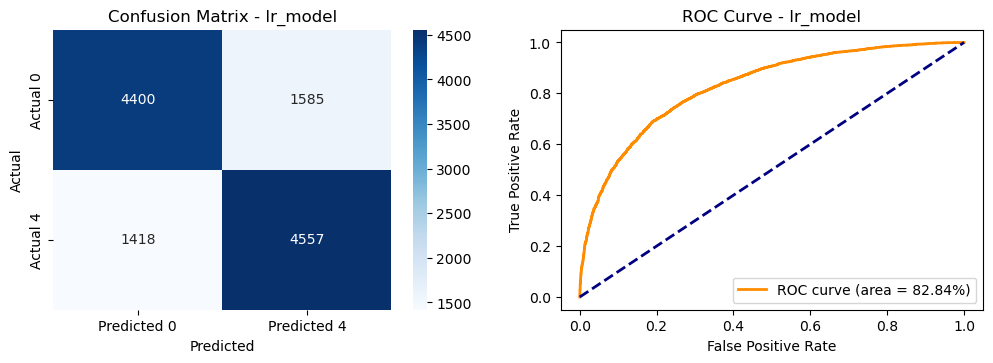

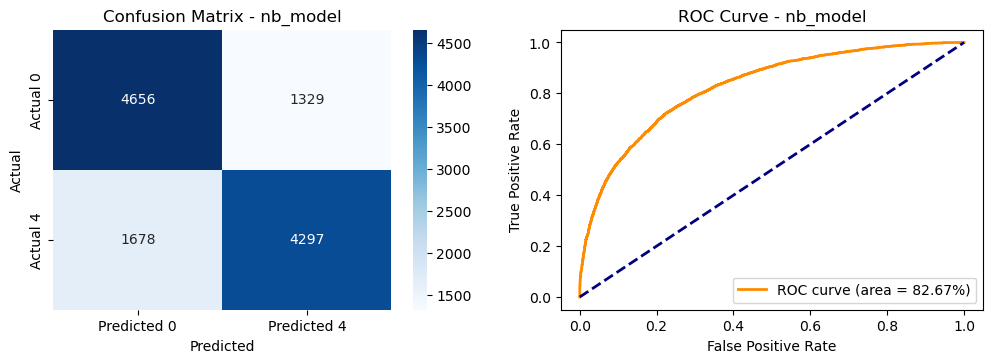

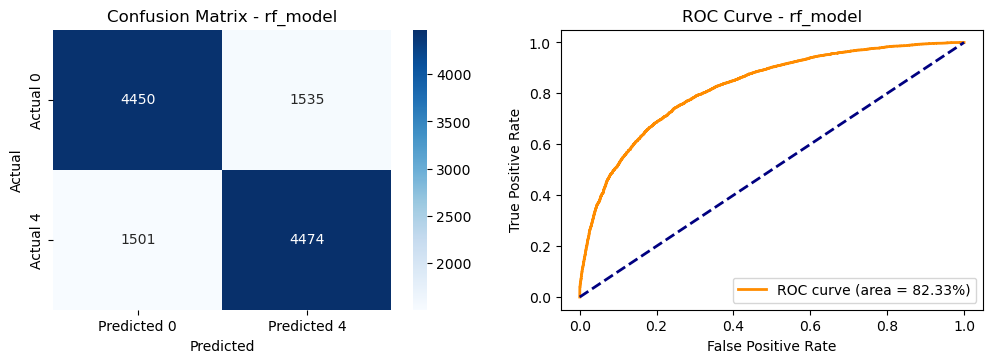

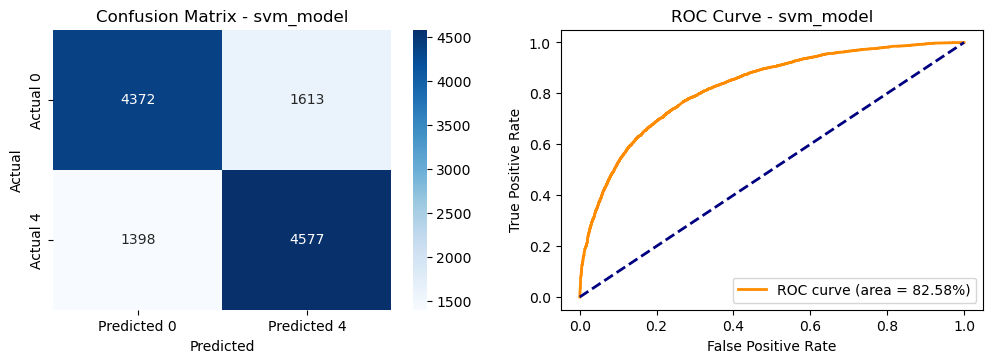

In [103]:
results_list = []

def evaluate_model(model, X, y, model_name, results_df):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    cm = confusion_matrix(y, y_pred)
    acc = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, pos_label=4) 
    recall = recall_score(y, y_pred, pos_label=4) 
    f1 = f1_score(y, y_pred, pos_label=4)

    fpr, tpr, thresholds = roc_curve(y, y_prob, pos_label=4)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 4'], yticklabels=['Actual 0', 'Actual 4'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.subplot(2, 2, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc * 100:.2f}%)')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")

    result = {
        'Model': model_name,
        'Confusion Matrix': cm,
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }

    results_list.append(result)

    return results_list

models = {'lr_model': lr_model, 'nb_model': nb_model, 'rf_model': rf_model, 'svm_model': svm_model}

for model_name, model in models.items():
    results_list = evaluate_model(model, X_test_ml, y_test_ml, model_name, results_list)

  1/187 [..............................] - ETA: 5s

187/187 [==============================] - 4s 22ms/step

Results Summary:
 [{'Model': 'lr_model', 'Confusion Matrix': array([[4400, 1585],
       [1418, 4557]]), 'Accuracy': 0.7489130434782608, 'Precision': 0.7419407359166396, 'Recall': 0.7626778242677824, 'F1 Score': 0.7521663778162911, 'ROC AUC': 0.8283720458747985}, {'Model': 'nb_model', 'Confusion Matrix': array([[4656, 1329],
       [1678, 4297]]), 'Accuracy': 0.7485785953177257, 'Precision': 0.7637753288304302, 'Recall': 0.719163179916318, 'F1 Score': 0.7407982070511162, 'ROC AUC': 0.8267387576332742}, {'Model': 'rf_model', 'Confusion Matrix': array([[4450, 1535],
       [1501, 4474]]), 'Accuracy': 0.7461538461538462, 'Precision': 0.7445498419038109, 'Recall': 0.748786610878661, 'F1 Score': 0.7466622162883845, 'ROC AUC': 0.8232524686891567}, {'Model': 'svm_model', 'Confusion Matrix': array([[4372, 1613],
       [1398, 4577]]), 'Accuracy': 0.7482441471571907, 'Precision': 0.7394184168012924, 'Recall': 0.7660251046025105, 'F1 Score

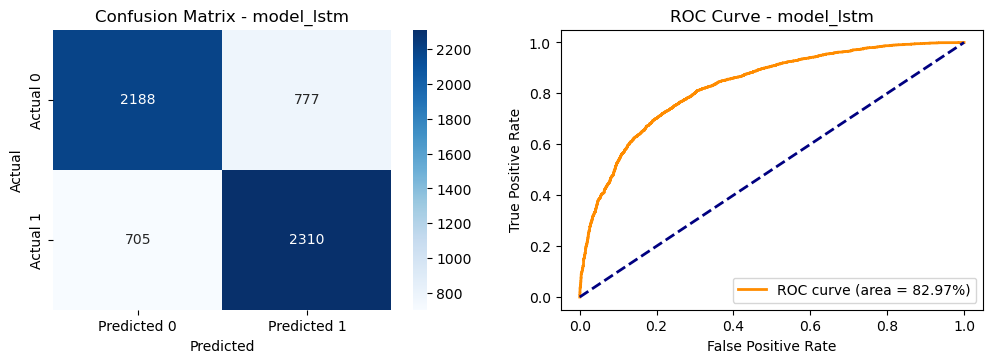

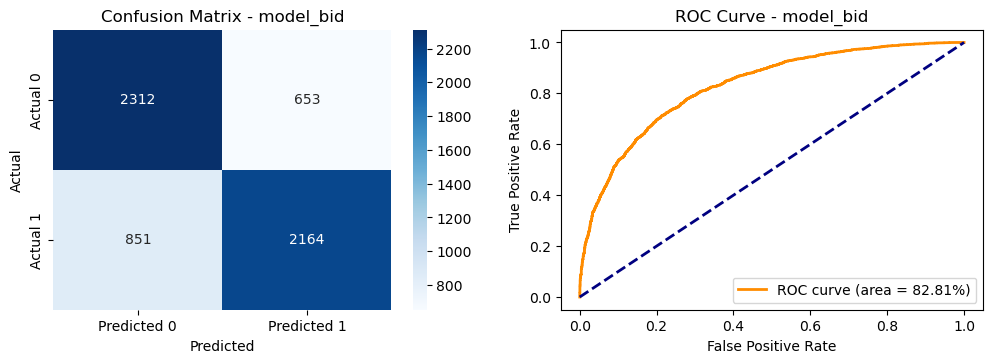

In [104]:
def evaluate_deep_model(model, X, y, model_name, results_list):
    y_prob = model.predict(X)  
    y_pred = np.round(y_prob)
    cm = confusion_matrix(y, y_pred)
    acc = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, pos_label=1)  
    recall = recall_score(y, y_pred, pos_label=1)  
    f1 = f1_score(y, y_pred, pos_label=1)  
    fpr, tpr, thresholds = roc_curve(y, y_prob, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.subplot(2, 2, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc * 100:.2f}%)')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")

    result = {
        'Model': model_name,
        'Confusion Matrix': cm,
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }

    results_list.append(result)

    return results_list

deep_models = {'model_lstm': model_lstm, 'model_bid': model_bid}

for model_name, deep_model in deep_models.items():
    results_list = evaluate_deep_model(deep_model, X_test_padded, y_test_encoded, model_name, results_list)

print("\nResults Summary:\n", results_list)


In [105]:
results_df = pd.DataFrame(results_list)
results_subset_df = results_df[['Model','Accuracy','Precision','Recall','F1 Score','ROC AUC']]
print(results_subset_df)

        Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0    lr_model  0.748913   0.741941  0.762678  0.752166  0.828372
1    nb_model  0.748579   0.763775  0.719163  0.740798  0.826739
2    rf_model  0.746154   0.744550  0.748787  0.746662  0.823252
3   svm_model  0.748244   0.739418  0.766025  0.752487  0.825753
4  model_lstm  0.752174   0.748299  0.766169  0.757129  0.829685
5   model_bid  0.748495   0.768193  0.717745  0.742112  0.828100
